In [1]:
import numpy as np
from matplotlib import pyplot as plt
import requests
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_csv('airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
def preprocess(y, features=2):

    T = len(y)
    y = y.astype(float)
    scale = np.max(y)
    y /= scale
    
    X = np.zeros((T, features))
    for t in range(T):
        X[t] += [y[t+i] if (t+i) < T else 0 for i in range(features)]

    y = np.array([y[i+features] if i+features < len(y) else 0 for i in range(len(y))], dtype=float)
    
    return scale, X, y

In [4]:
def noisy(X, std=.02):

    noise = np.random.normal(0, std, size=X.shape)
    return np.clip(X+noise, a_min=0, a_max=None)


In [64]:
feats = 3

y = df['Passengers'].to_numpy()
scale, X, y = preprocess(y, features=feats)
X = noisy(X, std=.002)

#Spliteo en train/test
x_train, x_test = np.split(X, [int(.8*X.shape[0])])
y_train, y_test = np.split(y, [int(.8*y.shape[0])])

#Agrego un eje 'temporal' que sirve de entrada para el bloque LSTM
x_train = x_train[:, np.newaxis, :]
x_test = x_test[:, np.newaxis, :]

x_train.shape, y_test.shape

((115, 1, 3), (29,))

In [65]:
keras.backend.clear_session()

model = keras.models.Sequential(name='LSTM')

model.add(keras.layers.Input(shape=(1, feats)))
model.add(keras.layers.LSTM(10, return_sequences=True))
model.add(keras.layers.LSTM(20, return_sequences=False))
#model.add(keras.layers.LSTM(20, return_sequences=True))
#model.add(keras.layers.LSTM(20))

model.add(keras.layers.Dense(1))

model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 10)             560       
                                                                 
 lstm_1 (LSTM)               (None, 20)                2480      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 3,061
Trainable params: 3,061
Non-trainable params: 0
_________________________________________________________________


In [66]:
opt = keras.optimizers.Adam()


model.compile(optimizer=opt, loss='MSE',
              metrics=['MSE'])

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                 epochs=500, verbose=0, batch_size=32)

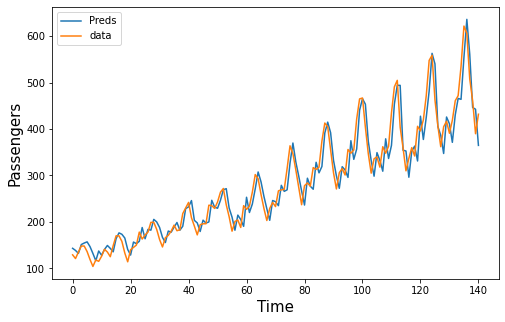

In [70]:
preds = model.predict(X[:, np.newaxis, :], verbose=0)[:-1]
yy = np.zeros_like(preds)
yy = y[:len(y)-feats]

plt.figure(figsize=(8,5))
plt.plot(preds[:len(y)-feats]*scale, label='Preds')
plt.plot(yy*scale, label='data')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Passengers', fontsize=15)
plt.legend(loc='best');

In [72]:
model2 = keras.models.Sequential(name='Dense')


model2.add(keras.layers.Input(shape=(1, feats)))
model2.add(keras.layers.Flatten())

model2.add(keras.layers.Dense(feats))
model2.add(keras.layers.Dense(100))
model2.add(keras.layers.Dense(100))
model2.add(keras.layers.Dense(1))

model2.summary()

Model: "Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 100)               400       
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,613
Trainable params: 10,613
Non-trainable params: 0
_________________________________________________________________


In [73]:
opt = keras.optimizers.Adam()


model2.compile(optimizer=opt, loss='MSE',
              metrics=['MSE'])

hist = model2.fit(x_train, y_train, validation_data=(x_test, y_test), 
                 epochs=500, verbose=0, batch_size=32)

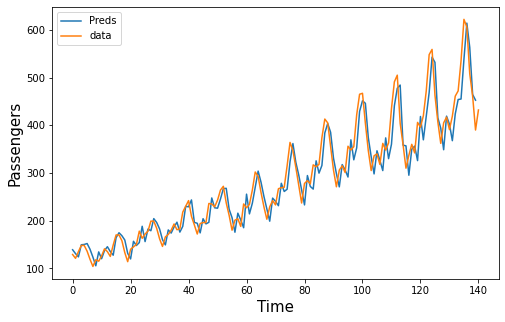

In [87]:
preds2 = model2.predict(X[:, np.newaxis, :], verbose=0)[:-1]
yy = np.zeros_like(preds2)
yy = y[:len(y)-feats]

plt.figure(figsize=(8,5))
plt.plot(preds2[:-feats]*scale, label='Preds')
plt.plot(yy*scale, label='data')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Passengers', fontsize=15)
plt.legend(loc='best');

